<a href="https://colab.research.google.com/github/SaifEleslamElgalaly/food-101-classification/blob/main/Loading%20and%20Preprocessing%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive and copy dataset if needed
from google.colab import drive
import os, shutil, stat, collections
from collections import defaultdict

In [ ]:
drive.mount('/content/drive')
!cp -r "/content/drive/Othercomputers/food-101" "/content/"
data_path = "/content/food-101"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1) استيراد المكتبات
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

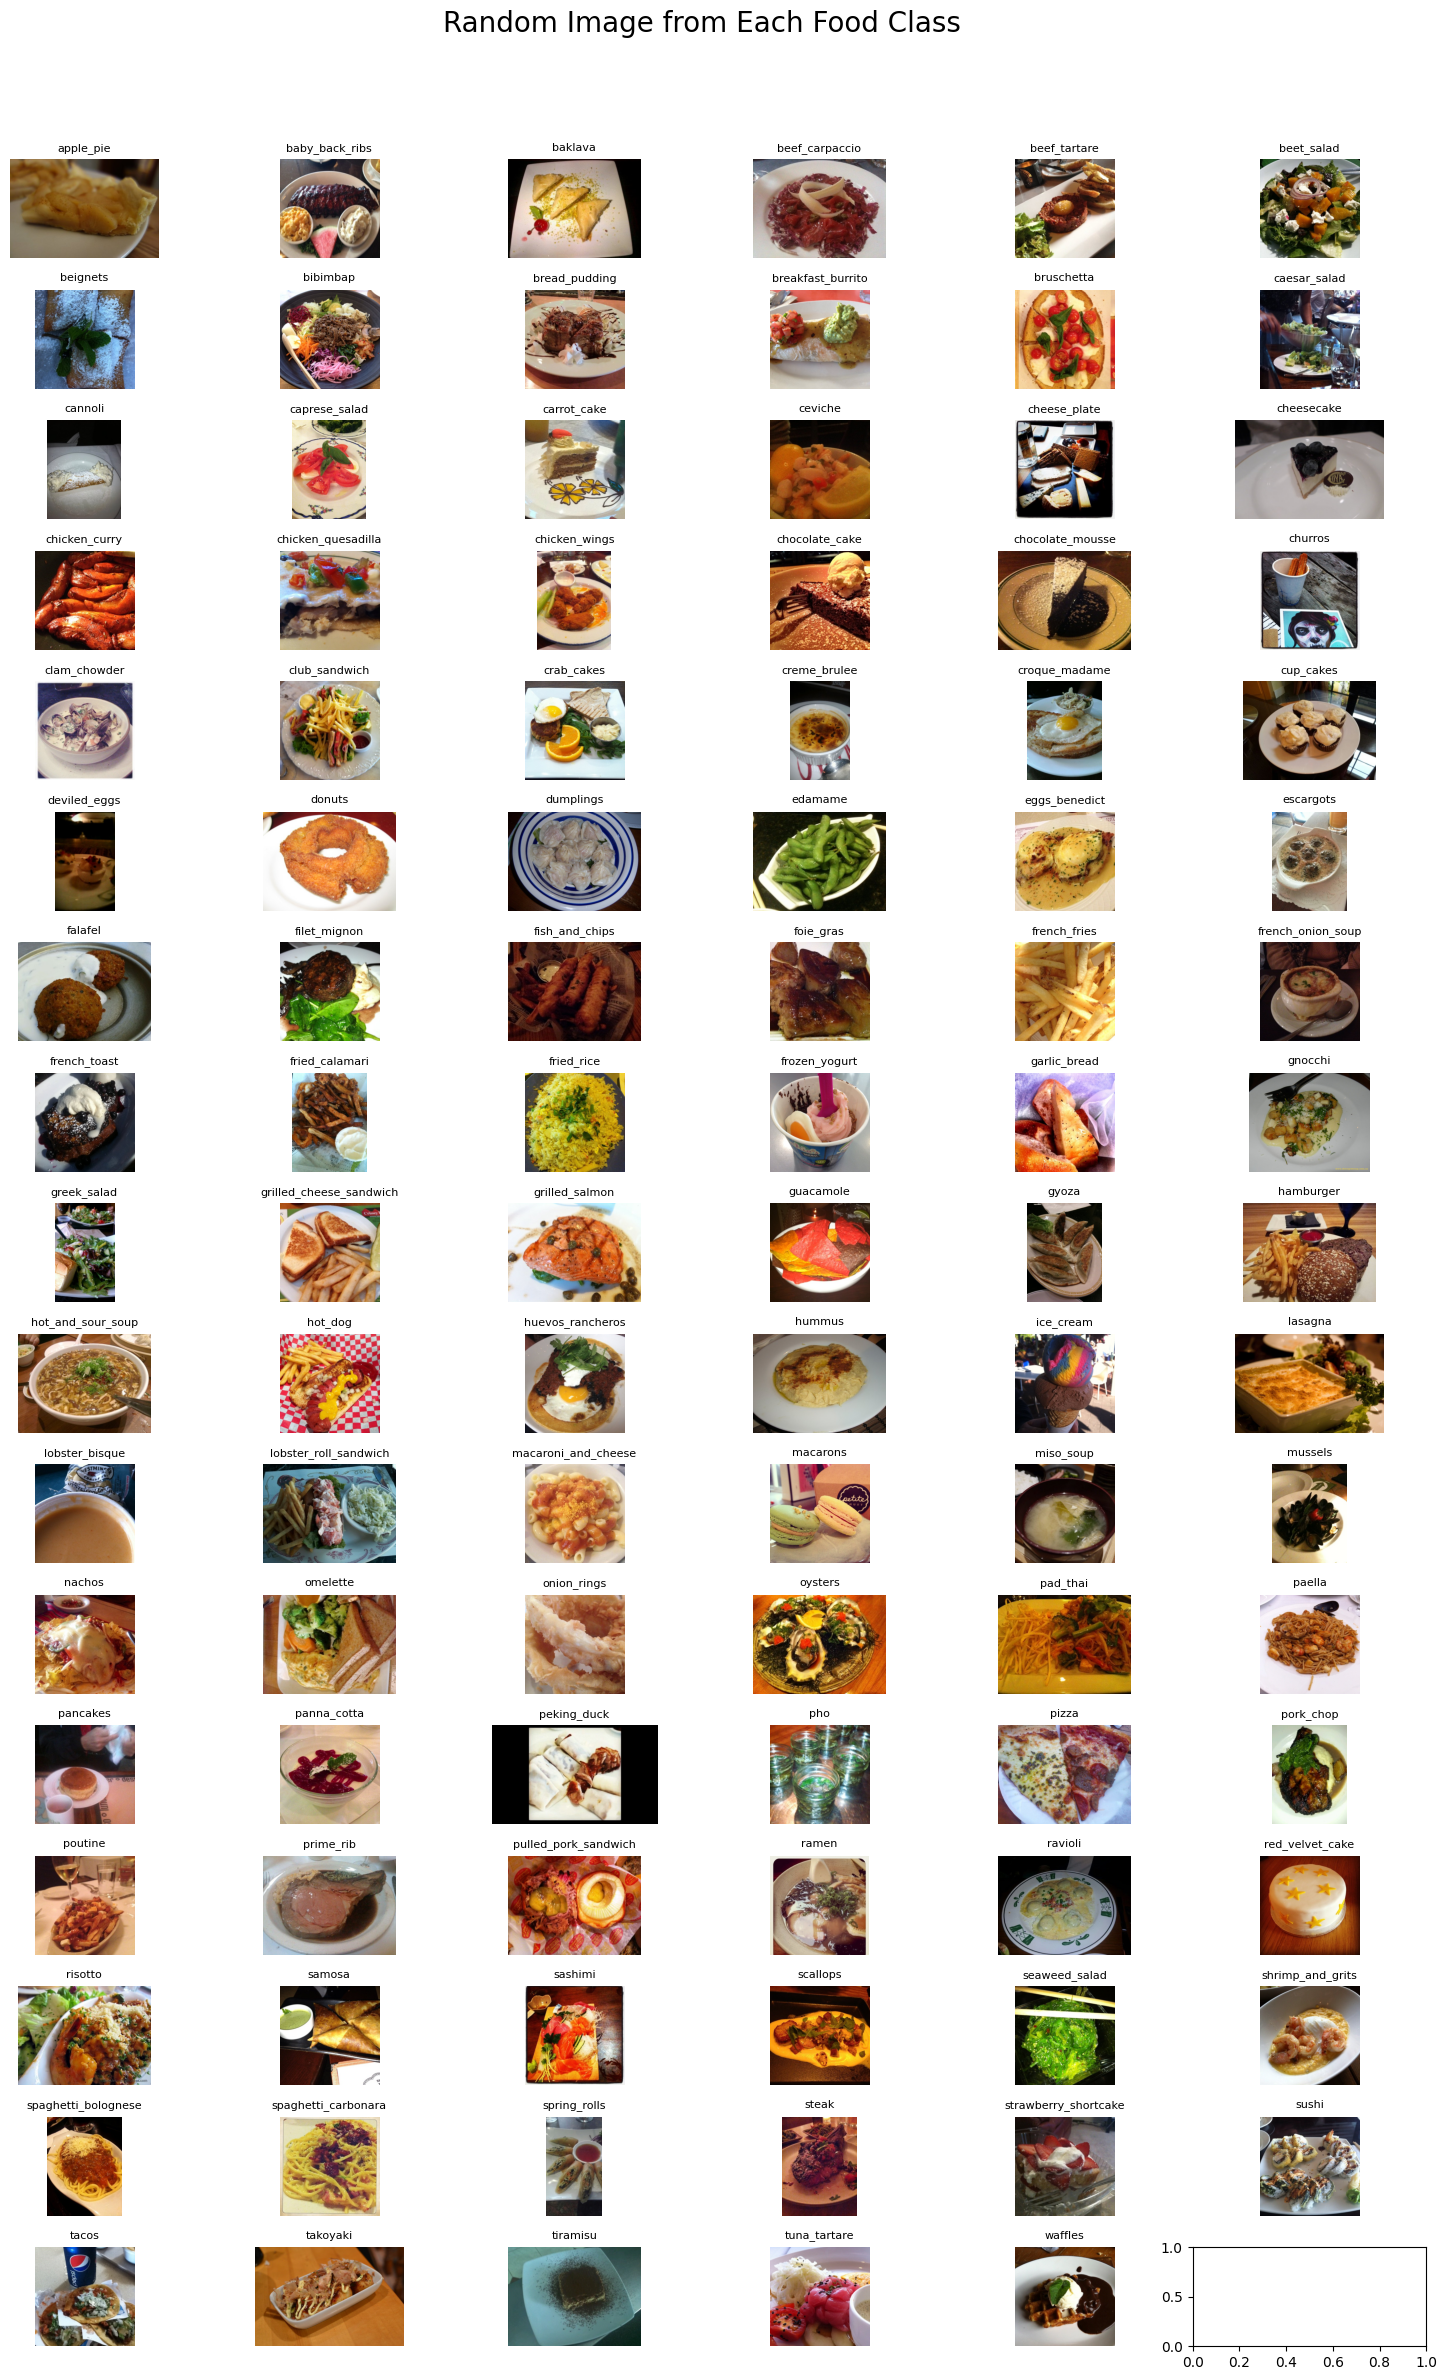

In [ ]:
# 2) عرض صورة عشوائية من كل كلاس
root_dir = os.path.join(data_path, 'images')
rows, cols = 17, 6
fig, ax = plt.subplots(rows, cols, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        idx = i * cols + j
        if idx >= len(sorted_food_dirs): break
        food_dir = sorted_food_dirs[idx]
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        img_name = np.random.choice(all_files)
        im = Image.open(os.path.join(root_dir, food_dir, img_name))
        ax[i][j].imshow(im)
        ax[i][j].set_title(food_dir, fontsize=8)
        ax[i][j].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
# 3) تجهيز التوازي (multiprocessing)
num_processes = 6
pool = mp.Pool(processes=num_processes)

In [ ]:
# 4) بناء خريطة الكلاسات
class_to_ix, ix_to_class = {}, {}
with open(os.path.join(data_path, 'meta', 'classes.txt'), 'r') as f:
    classes = [l.strip() for l in f]
    class_to_ix = {c:i for i,c in enumerate(classes)}
    ix_to_class = {i:c for i,c in enumerate(classes)}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))


In [ ]:
# 5) تقسيم الصور إلى مجلدات train / test (مرة واحدة)
def generate_dir_file_map(path_txt):
    d = defaultdict(list)
    with open(path_txt) as f:
        for line in f:
            dir_name, fname = line.strip().split('/')
            d[dir_name].append(fname + '.jpg')
    return d

train_map = generate_dir_file_map(os.path.join(data_path, 'meta', 'train.txt'))
test_map  = generate_dir_file_map(os.path.join(data_path, 'meta', 'test.txt'))

def copytree(src, dst, ignore_map):
    if not os.path.exists(dst):
        os.makedirs(dst)
    for class_name in os.listdir(src):
        sdir = os.path.join(src, class_name)
        ddir = os.path.join(dst, class_name)
        os.makedirs(ddir, exist_ok=True)
        for img_name in os.listdir(sdir):
            keep = img_name in ignore_map[class_name]
            if keep:
                shutil.copy(os.path.join(sdir, img_name), os.path.join(ddir, img_name))

if not os.path.isdir(os.path.join(data_path, 'train')):
    copytree(os.path.join(data_path, 'images'), os.path.join(data_path, 'train'), train_map)
if not os.path.isdir(os.path.join(data_path, 'test')):
    copytree(os.path.join(data_path, 'images'), os.path.join(data_path, 'test'), test_map)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation للـ Train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test ما نعمللهمش Augmentation بس نعمل Rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# توليد الداتا أثناء التدريب
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
